In [1]:
import torch
import torch.nn as nn
from transformers import ASTConfig, ASTModel, ASTFeatureExtractor
import numpy as np
import librosa
import os
import glob
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt

C:\Users\dave\anaconda3\envs\haikoo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch is using GPU 🟢")
else:
    device = torch.device("cpu")
    print("PyTorch is using CPU 🟡")

PyTorch is using GPU 🟢


In [3]:
dir_path = r"C:\Users\dave\aiffel\EUANGGG\maincode\data\dataset\audioonly\labeled\orig_resample"
os.path.exists(dir_path)

True

In [4]:
class_name = next(os.walk(dir_path))[1]
class_name

['bellypain', 'discomfort', 'hungry', 'tired']

In [5]:
audio_dir = [os.path.join(dir_path, name) for name in class_name]
audio_dir

['C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\orig_resample\\bellypain',
 'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\orig_resample\\discomfort',
 'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\orig_resample\\hungry',
 'C:\\Users\\dave\\aiffel\\EUANGGG\\maincode\\data\\dataset\\audioonly\\labeled\\orig_resample\\tired']

In [6]:
bpain_audio = glob.glob(os.path.join(audio_dir[0], '*.wav'))
discomf_audio = glob.glob(os.path.join(audio_dir[1], '*.wav'))
hungry_audio = glob.glob(os.path.join(audio_dir[2], '*.wav'))
tired_audio = glob.glob(os.path.join(audio_dir[3], '*.wav'))

In [7]:
len(hungry_audio)

50

In [8]:
audio_path_class = {
    'bpain': bpain_audio,
    'discomf': discomf_audio,
    'hungry': hungry_audio,
    'tired': tired_audio
}

## **전처리 하기**

In [9]:
def convert_audio(pathdict):
    audio_load = {}

    for class_name, path in tqdm(pathdict.items()):
        temp = []
        for file in path:
            audio, sr = librosa.load(file, sr = 20000)
            temp.append(audio)
        audio_load[class_name] = temp
    return audio_load

In [10]:
loaded_audio = convert_audio(audio_path_class)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.48it/s]


In [11]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", sampling_rate=20000)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


## **훈련데이터 및 테스트셋 만들기**

In [12]:
input_byclass = {}
for class_name, audio_load in loaded_audio.items():
    temp = []
    for audio in audio_load:
        input = processor(audio, sampling_rate = 20000, return_tensor = 'np')
        temp.append(input['input_values'])
    input_byclass[class_name] = np.array(temp)

In [13]:
all_data = []
all_labels = []

for label, class_data in enumerate(input_byclass):
    all_data.append(input_byclass[class_data])
    all_labels.append(np.full(len(input_byclass[class_data]), label))

In [14]:
all_data = np.concatenate(all_data, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [15]:
all_data.shape

(197, 1, 1024, 128)

In [16]:
squeezed_data_np = np.squeeze(all_data, axis = 1)
squeezed_data_np.shape

(197, 1024, 128)

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(squeezed_data_np, all_labels, test_size = 0.2, random_state = 31)

In [18]:
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = 0.5, random_state = 33)

In [19]:
# Convert to PyTorch tensors
xtrain_tensor = torch.tensor(x_train, dtype=torch.float32)
xval_tensor = torch.tensor(x_val, dtype=torch.float32)

ytrain_tensor = torch.tensor(y_train, dtype=torch.long)
yval_tensor = torch.tensor(y_val, dtype=torch.long)

xtest_tensor = torch.tensor(x_test, dtype=torch.float32)
ytest_tensor = torch.tensor(y_test, dtype=torch.long)

In [20]:
print(xtrain_tensor.shape)
print(xval_tensor.shape)
print(ytrain_tensor.shape)
print(yval_tensor.shape)
print(xtest_tensor.shape)
print(ytest_tensor.shape)

torch.Size([157, 1024, 128])
torch.Size([20, 1024, 128])
torch.Size([157])
torch.Size([20])
torch.Size([20, 1024, 128])
torch.Size([20])


In [21]:
train_dataset = TensorDataset(xtrain_tensor, ytrain_tensor)
val_dataset = TensorDataset(xval_tensor, yval_tensor)
test_dataset = TensorDataset(xtest_tensor, ytest_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

## **모델 불러오기**

In [22]:
import torch.nn.functional as F
class CustomASTClassifier(nn.Module):
    def __init__(self, ast_model_name, num_labels):
        super().__init__()
        # self.astconfig = ASTConfig() # 괄호 안에 configuration 값 넣어주면 됩니다. 아마 sampling rate도 20000으로 맞춰주시면 될 것 같아요.
        self.ast = ASTModel.from_pretrained(ast_model_name) # 요거 안되면 질문주세요
        self.num_labels = num_labels
        for param in self.ast.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(48, 4)
        self.dense1 = nn.Linear(768, 192)
        self.dense2 = nn.Linear(192, 96)
        self.dense3 = nn.Linear(96, 48)
        self.activation = nn.GELU()
        self.layernorm = nn.LayerNorm(self.ast.config.hidden_size, self.ast.config.layer_norm_eps)

    def forward(self, input_values, labels=None):
        input_values = input_values.float()
        outputs = self.ast(input_values)
        pooled_output = outputs[1]
        # flat_embed = embeddings.view(embeddings.size(0), -1)
        # x = self.layernorm(pooled_output)
        x = self.dense1(pooled_output)
        x = self.activation(x)
        x = self.dense2(x)
        x = self.activation(x)
        x = self.dense3(x)
        x = self.activation(x)
        logits = self.classifier(x)
        
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1).long())
            return loss, logits
        return logits

In [23]:
import torch.optim as optim
import matplotlib.pyplot as plt

num_labels = 4
ast_model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
model = CustomASTClassifier(ast_model_name, num_labels).to(device)

# Define your optimizer, loss function, etc.
optimizer = optim.Adam(model.parameters(), lr=2.089296130854041e-04)

# Initialize metric lists
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

In [24]:
# 여기서 ast 모델이 다 freeze 됐는지 확인하시면 되요
for name, param in model.ast.named_parameters():
    if param.requires_grad:
        print(f"{name}: requires_grad is True")
    else:
        print(f"{name}: requires_grad is False")

embeddings.cls_token: requires_grad is False
embeddings.distillation_token: requires_grad is False
embeddings.position_embeddings: requires_grad is False
embeddings.patch_embeddings.projection.weight: requires_grad is False
embeddings.patch_embeddings.projection.bias: requires_grad is False
encoder.layer.0.attention.attention.query.weight: requires_grad is False
encoder.layer.0.attention.attention.query.bias: requires_grad is False
encoder.layer.0.attention.attention.key.weight: requires_grad is False
encoder.layer.0.attention.attention.key.bias: requires_grad is False
encoder.layer.0.attention.attention.value.weight: requires_grad is False
encoder.layer.0.attention.attention.value.bias: requires_grad is False
encoder.layer.0.attention.output.dense.weight: requires_grad is False
encoder.layer.0.attention.output.dense.bias: requires_grad is False
encoder.layer.0.intermediate.dense.weight: requires_grad is False
encoder.layer.0.intermediate.dense.bias: requires_grad is False
encoder.laye

In [25]:
# Training loop
for epoch in range(40):  
    total_loss, correct, total = 0, 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    # Training phase
    for batch in train_loader:
        optimizer.zero_grad()
        input_values, labels = batch
        input_values, labels = input_values.to(device), labels.to(device)

        loss, logits = model(input_values, labels)
        total_loss += loss.item()

        # Calculate accuracy
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

    train_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    if val_loader is not None:
        model.eval()
        with torch.no_grad():
            val_loss, correct, total = 0, 0, 0
            for batch in val_loader:
                input_values, labels = batch
                input_values, labels = input_values.to(device), labels.to(device)

                loss, logits = model(input_values, labels)
                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            val_accuracy = correct / total
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_accuracy)

        model.train()

Epoch 1:   0%|                                                                       | 0/20 [00:11<?, ?it/s, loss=1.45]

Epoch 3:   0%|                                                                      | 0/20 [00:11<?, ?it/s, loss=0.961]

Epoch 5:   0%|                                                                       | 0/20 [00:11<?, ?it/s, loss=1.09]

Epoch 7:   0%|                                                                      | 0/20 [00:11<?, ?it/s, loss=0.599]

Epoch 9:   0%|                                                                      | 0/20 [00:11<?, ?it/s, loss=0.303]

Epoch 11:   0%|                                                                     | 0/20 [00:11<?, ?it/s, loss=0.213]

Epoch 13:   0%|                                                                      | 0/20 [00:11<?, ?it/s, loss=0.47]

Epoch 15:   0%|                                                                     | 0/20 [00:11<?, ?it/s, loss=0.341]

Epoch 17:   0%|                 

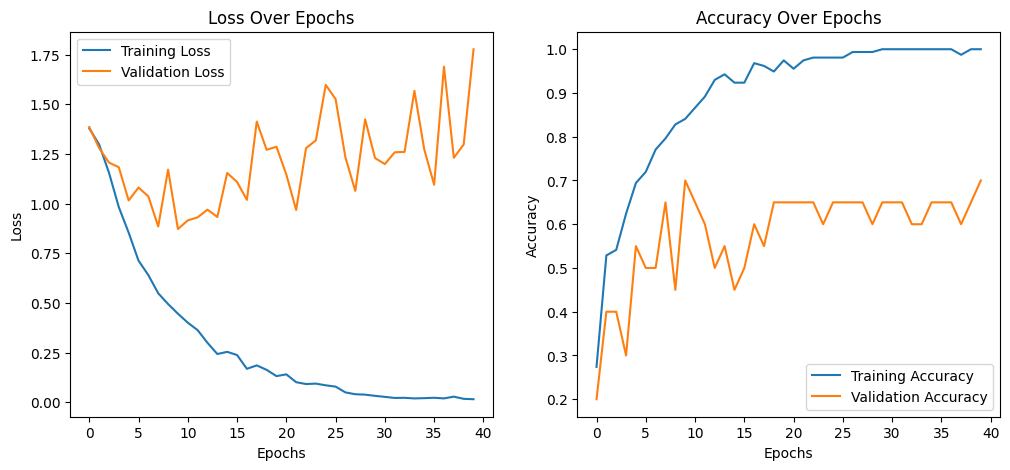

In [26]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
if val_loader is not None:
    plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
if val_loader is not None:
    plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# plt.savefig("win500_set2.2_test_epc200_flattened.png") # 그래프 사진은 주석풀어서 사진이름만 설정해주시면 됩니다.

plt.show()

In [27]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
with torch.no_grad():  # Disable gradient computation
    for data in test_loader:  # dataloader is your DataLoader for the dataset
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 55.00%
